In [2]:
RETRAIN = False

In [2]:
!pip install xmltodict

In [4]:
paths = {'PKLot': ["PKLot/PKLot/PKLotSegmented/", "splits/PKLot/train.txt", "splits/PKLot/test.txt"],
         'CNR-EXT': ['CNR-EXT-Patches-150x150/PATCHES', 'splits/CNRPark-EXT/train.txt', 'splits/CNRPark-EXT/test.txt'],
         'CNRPark': ['CNRPark-Patches-150x150/', 'splits/CNRParkAB/train.txt', 'splits/CNRParkAB/val.txt']}

In [5]:
import os   
import cv2
import torch
import argparse
import xmltodict
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

class Data:
    def __init__(self, img_path, target_path, transforms = None):
        with open(target_path, 'r') as f:
            lines = f.readlines()
            self.img_list = [os.path.join(img_path, i.split()[0]) for i in lines]
            self.label_list = [i.split()[1] for i in lines]
            self.transforms = transforms
    
    def __getitem__(self, index):
        try:
            img_path = self.img_list[index]
            img = Image.open(img_path)
            img = self.transforms(img)
            label = self.label_list[index]
        except:
            return None
        return img, label
    
    def __len__(self):
        return len(self.label_list)

In [6]:
def imshow(train_loader):
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    img = torchvision.utils.make_grid(images)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=2, init_weights=False):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 48, 11, 4, 2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 2), 
        nn.Conv2d(48, 128, kernel_size=5, padding=2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),        
        nn.Conv2d(128, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(128 * 6 * 6, 2048),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(2048, 2048),
      nn.ReLU(inplace=True),
      nn.Linear(2048, num_classes),
    )
    if init_weights:
      self._initialize_weights()
  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      return self.classifier(x)

  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0) 


class mAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.input_channel = 3
        self.num_output = num_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channel, out_channels= 16, kernel_size= 11, stride= 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 16, out_channels= 20, kernel_size= 5, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= 20, out_channels= 30, kernel_size= 3, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(30*3*3, out_features=48),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Linear(in_features=48, out_features=2)
        )

    def forward(self, x):
        x = self.layer3(self.layer2(self.layer1(x)))
        x = x.view(x.size(0), -1)
        x = self.layer5(self.layer4(x))
        m = nn.Softmax(dim=1)
        return m(x)

In [8]:
def train(epoch, img_path, target_path, transform, net, criterion, device):
    train_dataset = Data(img_path, target_path, transform)
    train_loader = DataLoader(train_dataset, batch_size=64, \
            shuffle=True, num_workers=0,drop_last=False, collate_fn=collate_fn)
    epochLoss = []
    for ep in range(epoch):  
        if ep >= 12:
            learning_rate = 0.0025
        elif ep >= 6:
            learning_rate = 0.005
        else:
            learning_rate = 0.01
        running_loss = 0.0
        print("Epoch {}.".format(ep+1))
        for i, data in enumerate(train_loader,1):
            inputs, labels = data
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print("Epoch {}.\tBatch {}.\tLoss = {:.3f}.".format(ep+1, i+1, running_loss))
            if i % len(train_loader) == len(train_loader) - 1:    
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / len(train_loader)))
                epochLoss.append(running_loss)
                running_loss = 0.0

    print('Finished Training.')
    return epochLoss


In [9]:
def test(img_path, target_path, transform, net, device):
    print("\nTesting starts now...")
    test_dataset = Data(img_path, target_path, transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, \
                            num_workers=0, collate_fn=collate_fn)
    correct = 0
    total = 0
    item = 1
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            #print("Testing on batch {}".format(item))
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            images = images.to(device)
            labels = labels.to(device)
            y_pred.append(labels)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            item += 1
    return (correct/total), roc_auc_score(torch.cat(y_pred), torch.cat(y_true))


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),  # normalize to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

### Reprodução Tabela 2 do artigo do CNRPARK

In [11]:
paths

{'PKLot': ['PKLot/PKLot/PKLotSegmented/',
  'splits/PKLot/train.txt',
  'splits/PKLot/test.txt'],
 'CNR-EXT': ['CNR-EXT-Patches-150x150/PATCHES',
  'splits/CNRPark-EXT/train.txt',
  'splits/CNRPark-EXT/test.txt'],
 'CNRPark': ['CNRPark-Patches-150x150/',
  'splits/CNRParkAB/train.txt',
  'splits/CNRParkAB/val.txt']}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


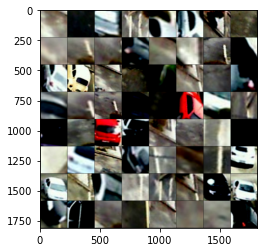

In [12]:
train_dataset = Data(paths['PKLot'][0], "splits/PKLot/UFPR04_train.txt", transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
imgs, labels = train_loader.__iter__().__next__()
imshow(train_loader)

#### Train On UFPR04

In [13]:
net = mAlexNet().to(device)
criterion = nn.CrossEntropyLoss()

In [14]:
if RETRAIN:
    loss = train(18, paths['PKLot'][0], "splits/PKLot/UFPR04_train.txt", transform, net, criterion, device)
    PATH = 'ufpr04Train.pth'
    torch.save(net.state_dict(), PATH)
    net.load_state_dict(torch.load(PATH))
else:
    PATH = 'ufpr04Train.pth'
    net.load_state_dict(torch.load(PATH))

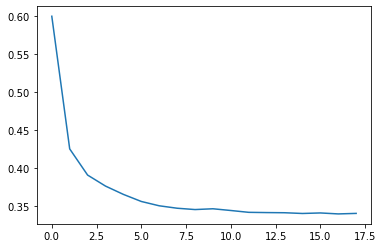

In [22]:
plt.plot([i/len(train_loader) for i in loss])

In [ ]:
with open("trainLossUFPR04.txt", "w") as file:
    file.write(loss)

In [35]:
resultsTable2 = pd.DataFrame()

In [36]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR04_train.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR04_train.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR04 Train"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR04_test' is 0.972.


In [37]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR04_test.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR04_test.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR04 Test"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR04_test' is 0.966.


In [38]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR05.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR05.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR05 All"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR05' is 0.746.


In [39]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/PUC.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/PUC.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["PUC All"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/PUC' is 0.923.


In [43]:
resultsTable2

,Dataset,Accuracy,Auc
0,UFPR04 Train,0.971949,0.971647
0,UFPR04 Test,0.966110,0.966037
0,UFPR05 All,0.746111,0.693283
0,PUC All,0.923312,0.926429


In [44]:
resultsTable2.to_csv("trainOnUFPR04Results.csv")

#### Train On UFPR05

In [ ]:
net = mAlexNet().to(device)
criterion = nn.CrossEntropyLoss()

In [46]:
RETRAIN = True

In [ ]:
if RETRAIN:
    loss = train(18, paths['PKLot'][0], "splits/PKLot/UFPR05_train.txt", transform, net, criterion, device)
    PATH = 'ufpr05Train.pth'
    torch.save(net.state_dict(), PATH)
    net.load_state_dict(torch.load(PATH))
else:
    PATH = 'ufpr05Train.pth'
    net.load_state_dict(torch.load(PATH))

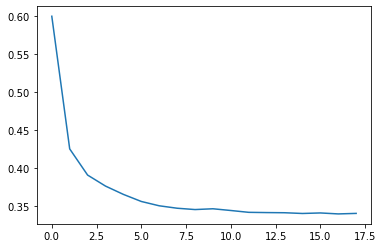

In [ ]:
plt.plot([i/len(train_loader) for i in loss])

In [ ]:
with open("trainLossUFPR05.txt", "w") as file:
    file.write(loss)

In [ ]:
resultsTable2 = pd.DataFrame()

In [ ]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR05_train.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR05_train.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR05 Train"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR04_test' is 0.972.


In [ ]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR05_test.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR05_test.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR05 Test"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR04_test' is 0.966.


In [ ]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR04.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR04.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR04 All"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR05' is 0.746.


In [ ]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/PUC.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/PUC.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["PUC All"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/PUC' is 0.923.


In [ ]:
resultsTable2

,Dataset,Accuracy,Auc
0,UFPR04 Train,0.971949,0.971647
0,UFPR04 Test,0.966110,0.966037
0,UFPR05 All,0.746111,0.693283
0,PUC All,0.923312,0.926429


In [45]:
resultsTable2.to_csv("trainOnUFPR05Results.csv")

#### Train On PUC

In [ ]:
net = mAlexNet().to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
RETRAIN = True

In [ ]:
if RETRAIN:
    loss = train(18, paths['PKLot'][0], "splits/PKLot/PUC_train.txt", transform, net, criterion, device)
    PATH = 'ufpr05Train.pth'
    torch.save(net.state_dict(), PATH)
    net.load_state_dict(torch.load(PATH))
else:
    PATH = 'ufpr05Train.pth'
    net.load_state_dict(torch.load(PATH))

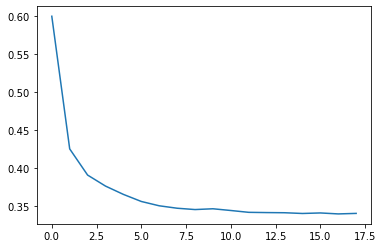

In [ ]:
plt.plot([i/len(train_loader) for i in loss])

In [ ]:
with open("trainLossUFPR05.txt", "w") as file:
    file.write(loss)

In [ ]:
resultsTable2 = pd.DataFrame()

In [ ]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR05_train.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR05_train.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR05 Train"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR04_test' is 0.972.


In [ ]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR05_test.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR05_test.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR05 Test"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR04_test' is 0.966.


In [ ]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR04.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR04.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["UFPR04 All"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR05' is 0.746.


In [ ]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/PUC.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/PUC.txt").split('.')[0], accuracy))
resultsTable2 = pd.concat([resultsTable2, pd.DataFrame({
                                        "Dataset": ["PUC All"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/PUC' is 0.923.


In [ ]:
resultsTable2

,Dataset,Accuracy,Auc
0,UFPR04 Train,0.971949,0.971647
0,UFPR04 Test,0.966110,0.966037
0,UFPR05 All,0.746111,0.693283
0,PUC All,0.923312,0.926429


In [ ]:
resultsTable2.to_csv("trainOnUFPR05Results.csv")

### Reprodução Tabela 3 do artigo do CNRPARK

#### Train On CNRPark

In [14]:
net = mAlexNet().to(device)
criterion = nn.CrossEntropyLoss()

In [15]:
paths

{'PKLot': ['PKLot/PKLot/PKLotSegmented/',
  'splits/PKLot/train.txt',
  'splits/PKLot/test.txt'],
 'CNR-EXT': ['CNR-EXT-Patches-150x150/PATCHES',
  'splits/CNRPark-EXT/train.txt',
  'splits/CNRPark-EXT/test.txt'],
 'CNRPark': ['CNRPark-Patches-150x150/',
  'splits/CNRParkAB/train.txt',
  'splits/CNRParkAB/val.txt']}

In [16]:
RETRAIN = True

In [17]:
if RETRAIN:
    loss = train(18, paths['CNRPark'][0], paths['CNRPark'][1], transform, net, criterion, device)
    PATH = 'CNRParkTrain.pth'
    torch.save(net.state_dict(), PATH)
    net.load_state_dict(torch.load(PATH))
else:
    PATH = 'CNRParkTrain.pth'
    net.load_state_dict(torch.load(PATH))

Epoch 1.
Epoch 1.	Batch 2.	Loss = 0.687.
Epoch 1.	Batch 3.	Loss = 1.371.
Epoch 1.	Batch 4.	Loss = 2.061.
Epoch 1.	Batch 5.	Loss = 2.747.
Epoch 1.	Batch 6.	Loss = 3.435.
Epoch 1.	Batch 7.	Loss = 4.125.
Epoch 1.	Batch 8.	Loss = 4.812.
Epoch 1.	Batch 9.	Loss = 5.499.
Epoch 1.	Batch 10.	Loss = 6.179.
Epoch 1.	Batch 11.	Loss = 6.864.
Epoch 1.	Batch 12.	Loss = 7.544.
Epoch 1.	Batch 13.	Loss = 8.230.
Epoch 1.	Batch 14.	Loss = 8.921.
Epoch 1.	Batch 15.	Loss = 9.605.
Epoch 1.	Batch 16.	Loss = 10.283.
Epoch 1.	Batch 17.	Loss = 10.959.
Epoch 1.	Batch 18.	Loss = 11.639.
Epoch 1.	Batch 19.	Loss = 12.319.
Epoch 1.	Batch 20.	Loss = 13.001.
Epoch 1.	Batch 21.	Loss = 13.677.
Epoch 1.	Batch 22.	Loss = 14.360.
Epoch 1.	Batch 23.	Loss = 15.045.
Epoch 1.	Batch 24.	Loss = 15.731.
Epoch 1.	Batch 25.	Loss = 16.411.
Epoch 1.	Batch 26.	Loss = 17.091.
Epoch 1.	Batch 27.	Loss = 17.758.
Epoch 1.	Batch 28.	Loss = 18.434.
Epoch 1.	Batch 29.	Loss = 19.112.
Epoch 1.	Batch 30.	Loss = 19.794.
Epoch 1.	Batch 31.	Loss = 2

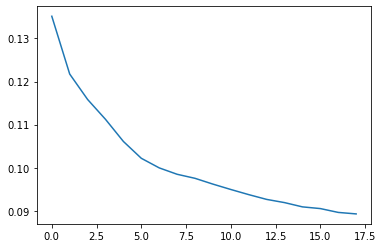

In [18]:
plt.plot([i/len(train_loader) for i in loss])

In [21]:
with open("trainLossCNRPark.txt", "w") as file:
    file.write(str(loss))

In [22]:
resultsTable3 = pd.DataFrame()

In [23]:
accuracy, auc = test(paths['CNR-EXT'][0], paths['CNR-EXT'][2], transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR05_train.txt").split('.')[0], accuracy))
resultsTable3 = pd.concat([resultsTable3, pd.DataFrame({
                                        "Dataset": ["CNR-EXT Test"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR05_train' is 0.810.


In [ ]:
accuracy, auc = test(paths['PKLot'][0], paths['PKLot'][2], transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR05_test.txt").split('.')[0], accuracy))
resultsTable3 = pd.concat([resultsTable3, pd.DataFrame({
                                        "Dataset": ["PKLot Test"],
                                        "Accuracy": [accuracy],
                                        "Auc": [auc]})])


Testing starts now...

The accuracy of training on 'PKLot/PKLot/PKLotSegmented/' and testing on 'splits/PKLot/UFPR04_test' is 0.966.


In [24]:
resultsTable3

,Dataset,Accuracy,Auc
0,CNR-EXT Test,0.80973,0.789083


In [ ]:
resultsTable3.to_csv("trainOnCNRParkResults.csv")

#### Train On CNRPark+EXT TRAIN C1-C8

#### Train On CNRPark+EXT TRAIN

#### Train On PKLot TRAIN

#### Train On PKLot2Days

#### Train On CNRPark

### Custom Image Inference

In [36]:
listi = []
names = []
for root, dirs, files in os.walk("PKLot/PKLot/PKLotSegmented/UFPR04/Sunny/2012-12-12"):
  for fil in files:
    if '2012-12-12_12_40_08' in fil:
      names.append(fil)
      if 'Empty' in root:
        listi.append((transform(Image.open(root + '/' + fil)), '0'))
      else:
        listi.append((transform(Image.open(root + '/' + fil)), '1'))
        
dl = DataLoader(listi, batch_size=1, shuffle=True, drop_last=False)

In [38]:
preds = []
correct = 0
total = 0
item = 1
for a in dl:
  images, labels = a
  labels = list(map(int, labels))
  labels = torch.Tensor(labels)
  images = images.to(device)
  labels = labels.to(device)

  outputs = net(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
  item += 1
  preds.append(predicted)

In [39]:
accuracy = correct/total
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format(("splits/CNRParkAB/even.txt").split('.')[0], ("splits/CNRParkAB/odd.txt").split('.')[0], accuracy))


The accuracy of training on 'splits/CNRParkAB/even' and testing on 'splits/CNRParkAB/odd' is 0.786.


In [41]:
with open('PKLot/PKLot/PKLot/UFPR04/Sunny/2012-12-12/2012-12-12_12_40_08.xml') as f:
  content=f.read()
  d = xmltodict.parse(content)
  coord = []
  for fil in names:
    coo = d['parking']['space'][int(fil[-7:-4])-1]['contour']['point']
    coord.append([[int(x['@x']), int(x['@y'])] for x in coo])

In [42]:
img = cv2.imread("PKLot/PKLot/PKLot/UFPR04/Sunny/2012-12-12/2012-12-12_12_40_08.jpg")

for i, co in enumerate(coord):
  pts = np.array(co, np.int32)
  pts = pts.reshape((-1,1,2))
  if listi[i][1] == '0':
    c = (0,255,255)
  else:
    c = (255, 0, 0)
  cv2.polylines(img,[pts],True,c, 2)

while(1):
     
    cv2.imshow('image', img)
    if cv2.waitKey(20) & 0xFF == 27:
        break
cv2.destroyAllWindows()